# Revisit of the biclosed module

## biclosed.Ty

Biclosed types are trees generated by Over and Under

In [1]:
from discopy import monoidal

class Ty(monoidal.Ty):
    @staticmethod
    def upgrade(old):
        if len(old) == 1 and isinstance(old[0], (Over, Under)):
            return old[0]
        return Ty(*old.objects)
        
    def __init__(self, *objects, left=None, right=None):
        self.left, self.right = left, right
        super().__init__(*objects)

    def __lshift__(self, other):
        return Over(self, other)

    def __rshift__(self, other):
        return Under(self, other)

    def __matmul__(self, other):
        return Ty(*(self.tensor(other)))


class Over(Ty):
    """ Forward slash types. """
    def __init__(self, left=None, right=None):
        Ty.__init__(self, self, left=left, right=right)

    def __repr__(self):
        return "Over({}, {})".format(repr(self.left), repr(self.right))

    def __str__(self):
        return "({} << {})".format(self.left, self.right)

    def __eq__(self, other):
        if not isinstance(other, Over):
            return False
        return self.left == other.left and self.right == other.right


class Under(Ty):
    """ Backward slash types. """
    def __init__(self, left=None, right=None):
        Ty.__init__(self, self, left=left, right=right)

    def __repr__(self):
        return "Under({}, {})".format(repr(self.left), repr(self.right))

    def __str__(self):
        return "({} >> {})".format(self.left, self.right)

    def __eq__(self, other):
        if not isinstance(other, Under):
            return False
        return self.left == other.left and self.right == other.right

In [2]:
x = Ty('x')
assert x >> x << x == Over(Under(Ty('x'), Ty('x')), Ty('x'))
assert x >> (x << x) == Under(Ty('x'), Over(Ty('x'), Ty('x')))
x0, x1, y0, y1, m = Ty('x0'), Ty('x1'), Ty('y0'), Ty('y1'), Ty('m')
lens = (x0 >> m @ y0) @ ( m @ x1 >> y1)
lens

Ty(Under(Ty('x0'), Ty('m', 'y0')), Under(Ty('m', 'x1'), Ty('y1')))

#### Interface with operad.Tree

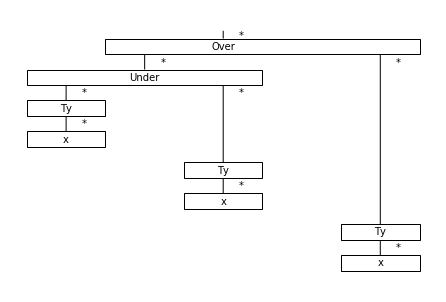

In [3]:
from discopy.operad import Box, Ob, tree2diagram

star = Ob('*')
UNDER = Box('Under', star, [star, star])
OVER = Box('Over', star, [star, star])
TY = lambda n: Box('Ty', star, n * [star])

def to_tree(ty):
    if isinstance(ty, Over):
        return OVER(to_tree(ty.left), to_tree(ty.right))
    if isinstance(ty, Under):
        return UNDER(to_tree(ty.left), to_tree(ty.right))
    if isinstance(ty, Ty):
        n = len(ty.objects)
        return TY(n)(*map(to_tree, ty.objects))
    if isinstance(ty, Ob):
        return Box(ty.name, star, [])
    raise NotImplementedError()

tree2diagram(to_tree(x >> x << x)).draw()

## biclosed.Diagram

Biclosed diagrams, i.e. arrows in free biclosed categories, are monoidal diagrams with two extra methods for currying and uncurrying diagrams.

In [6]:
from discopy import monoidal

@monoidal.Diagram.subclass
class Diagram(monoidal.Diagram):
    """ Diagrams in a biclosed monoidal category. """

    @staticmethod
    def curry(diagram, n_wires=1, left=False):
        """ Diagram currying. """
        return Curry(diagram, n_wires, left)

    @staticmethod
    def uncurry(diagram, n_wires=1, left=False):
        """ Diagram uncurrying. """
        return UnCurry(diagram, n_wires, left)

class Curry(Box):
    """
    Curried diagram.
    """
    def __init__(self, diagram, n_wires=1, left=False):
        if left:
            dom = diagram.dom[n_wires:]
            cod = diagram.dom[:n_wires] >> diagram.cod
        else:
            dom = diagram.dom[:-n_wires]
            cod = diagram.cod << diagram.dom[-n_wires or len(diagram.dom):]
        name = "Curry({}{}{})".format(
            diagram, ", n_wires={}".format(n_wires) if n_wires != 1 else "",
            ", left=True" if left else "")
        self.diagram, self.n_wires, self.left = diagram, n_wires, left
        super().__init__(name, dom, cod)


class UnCurry(Box):
    """
    Un-Curried diagram.
    """
    def __init__(self, diagram):
        name = "UnCurry({})".format(diagram)
        self.diagram = diagram
        if isinstance(diagram.cod, Over):
            dom = diagram.dom @ diagram.cod.right
            cod = diagram.dom.left
            super().__init__(name, dom, cod)
        elif isinstance(diagram.cod, Under):
            dom = diagram.dom.left @ diagram.dom
            cod = diagram.dom.right
            super().__init__(name, dom, cod)
        else:
            super().__init__(name, diagram.dom, diagram.cod)


class Id(monoidal.Id, Diagram):
    """ Identity diagram in a biclosed monoidal category. """


class Box(monoidal.Box, Diagram):
    """ Boxes in a biclosed monoidal category. """

## Categorial grammar

We recover the rules of categorial grammars (in historical order) by constructing them from the free biclosed category with no generators.

### Ajdiuciewicz

In [7]:
x, y, z = Ty('x'), Ty('y'), Ty('z')
FA = lambda x, y: UnCurry(Id(x >> y))
BA = lambda x, y: UnCurry(Id(y << x))

print('FA: ', FA(x, y).dom, ' ---> ', FA(x, y).cod)
print('BA: ', BA(x, y).dom, ' ---> ', BA(x, y).cod)

FA:  x @ (x >> y)  --->  y
BA:  (y << x) @ x  --->  y


### Lambek

FC:  (x >> y) @ (y >> z)  --->  (x >> z)
BC:  (x << y) @ (y << z)  --->  (x << z)


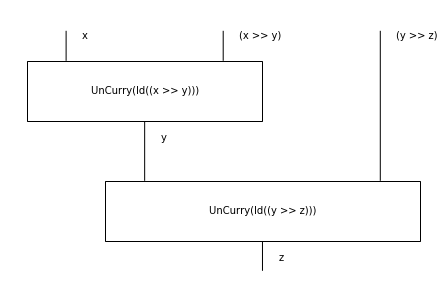

In [8]:
FC = Curry(FA(x, y) @ Id(y >> z) >> FA(y, z), left=True)
BC = Curry(Id(x << y) @ BA(z, y) >> BA(y, x))

print('FC: ', FC.dom, ' ---> ', FC.cod)
print('BC: ', BC.dom, ' ---> ', BC.cod)
proofFC = FA(x, y) @ Id(y >> z) >> FA(y, z)
proofFC.draw()

In [9]:
TYR = Curry(UnCurry(Id(x >> y)))
print('TYR: ', TYR.dom, ' ---> ', TYR.cod)

TYR:  x  --->  (y << (x >> y))


### CCG

BX:  (x << y) @ (z >> y)  --->  (x << z)


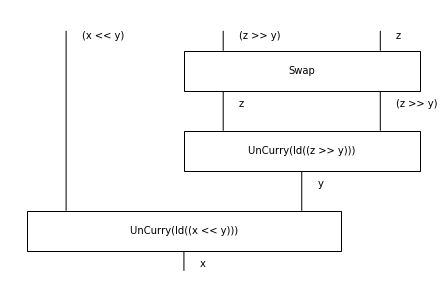

In [12]:
Swap = lambda a, b: Box('Swap', a @ b, b @ a)
proofBX = Id(x << y) @ (Swap(z >> y, z) >> FA(z, y)) >> BA(y, x)
BX = Curry(proofX)
print('BX: ', BX.dom, ' ---> ', BX.cod)
proofBX.draw()

FX:  (y << x) @ (y >> z)  --->  (x >> z)


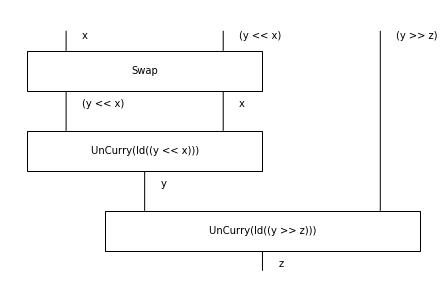

In [25]:
proofFX = (Swap(x, y << x) >> BA(x, y)) @ Id(y >> z) >> FA(y, z)
FX = Curry(proofFX, left=True)
print('FX: ', FX.dom, ' ---> ', FX.cod)
proofFX.draw()